In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='EDA'></a>
## Data Preprocessing and Exploratory Data Analyasis

In [4]:
train = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification/data/test.csv")
test_y = pd.read_csv("/content/drive/MyDrive/Toxic-Comment-Classification/data/test_labels.csv")

### Data Analysis

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
train.shape

(159571, 8)

In [10]:
test.shape

(153164, 2)

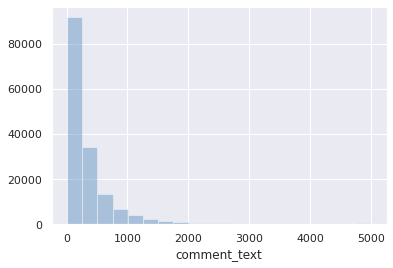

In [11]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [12]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

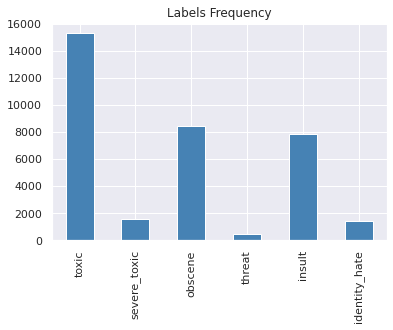

In [13]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [14]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [15]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

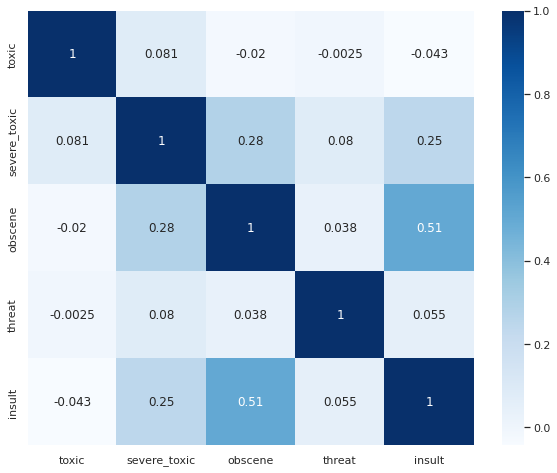

In [16]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [17]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

In [19]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

KeyboardInterrupt: ignored

<a id='Feature-engineering'></a>
## Feature-engineering

In [20]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [21]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [23]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [24]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

After the transformation, we can take a look at some of the features below.

In [25]:
vector.get_feature_names()[0:20]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

<a id='Modeling'></a>
## Modeling and Evaluation

### Baseline Model

We choose Naive Bayes as our baseline model, specifically Multinomial Naive Bayes.

Also, we want to compare between different models, especially models that perform well in text classification. Thus, we choose to compare Multinomial Naive Bayes with Logistic Regression and Linear Support Vector Machine.

### Evaluation Metrics

Our main metric for measuring model performance is F1-score, since we have 6 labels, the F1-score would be the average of 6 labels. We will also take other metrics into consideration while evaluating models, e.g, Hamming loss and recall.

<a id='cv'></a>
### Cross Validation

We use cross Validation to compare between the baseline model and the other two models that we have chosen (LogisticRegression and LinearSVC).

In [26]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [27]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [29]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

KeyboardInterrupt: ignored

In [ ]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.483066,0.636650
1,MultinomialNB,severe_toxic,0.021336,0.041091
2,MultinomialNB,obscene,0.469168,0.622147
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367144,0.511521
5,MultinomialNB,identity_hate,0.007837,0.015355
6,LogisticRegression,toxic,0.610500,0.731340
7,LogisticRegression,severe_toxic,0.256395,0.351711
8,LogisticRegression,obscene,0.636997,0.747361
9,LogisticRegression,threat,0.125665,0.210778


Based on the cross validation above, we noticed that overall, the linear SVC model and Logistic Regression model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the `threat` label and `identity_hate` label because these two labels have the least number of observations.

Now we want to see how these three models perform on the actual prediction - the test dataset.

### ⚔ Modeling and Evaluation

In [ ]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [ ]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [ ]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.935196,0.930919
1,MultinomialNB,severe_toxic,0.994436,0.992145
2,MultinomialNB,obscene,0.962987,0.957902
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,insult,0.960158,0.953453
5,MultinomialNB,identity_hate,0.988887,0.983408
6,LogisticRegression,toxic,0.935728,0.937031
7,LogisticRegression,severe_toxic,0.993107,0.992740
8,LogisticRegression,obscene,0.965957,0.964261
9,LogisticRegression,threat,0.996530,0.995725


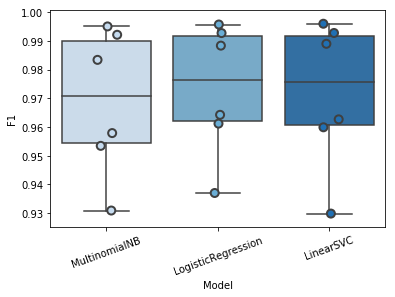

In [ ]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Above are the result table and plot showing a comparison between these different models after training them and see how these models perform on the test data.

Notice that Muninomial Naive Bayes does not perform as well as the other two models while Linear SVC in general out performs the others based on F1 score.

### Visualzing performance till now for each classifier across each category

Plot for Multinomial Naive Bayes regression


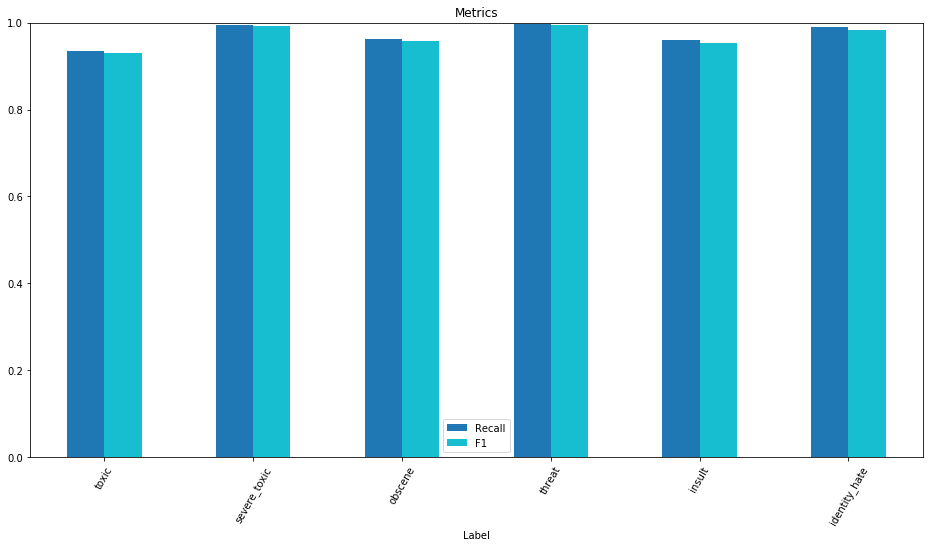

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Logistic regression


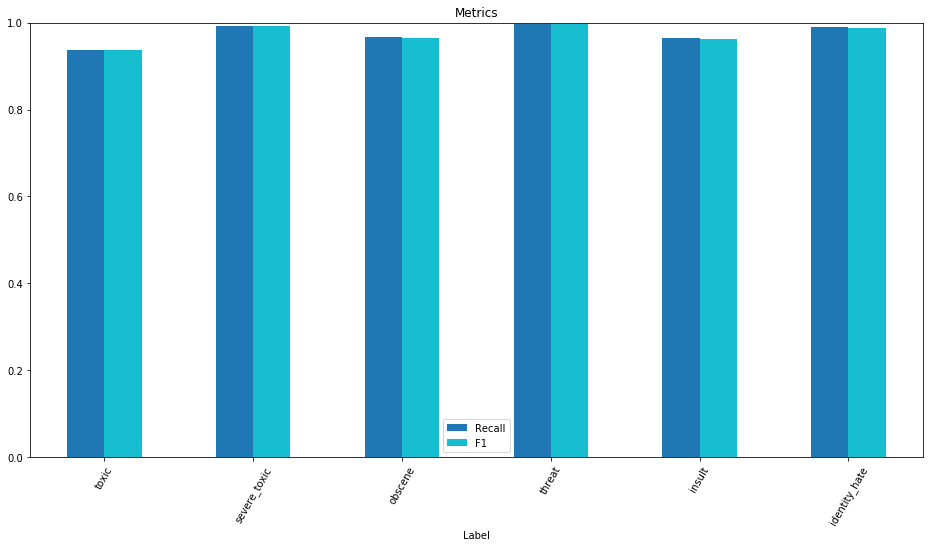

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


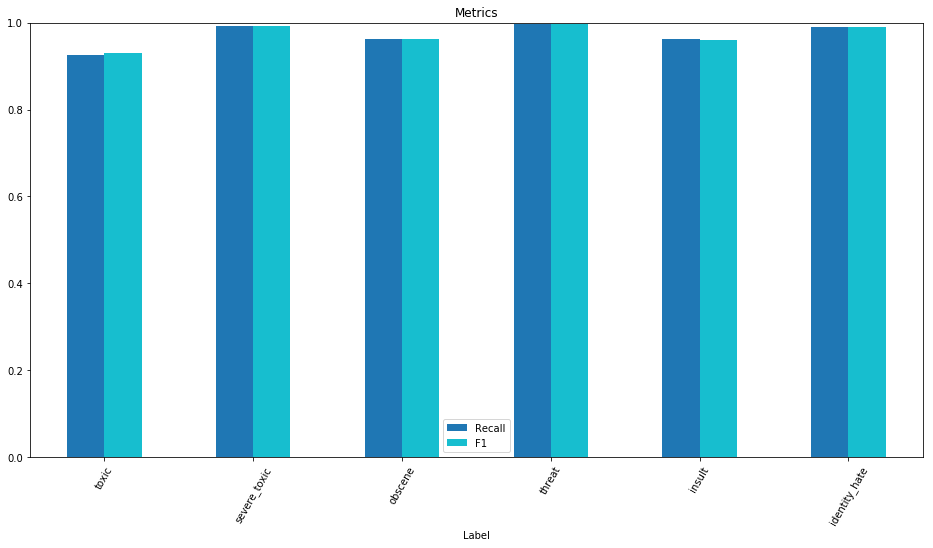

In [ ]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

<a id='model-comparison'></a>
###  Confusion Matrix visualization

In [ ]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [ ]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Below shows the confusion matrix for label `toxic`. Notice that all models predict Non-toxic labels pretty well because most of our data are non-toxic. However, Multinomial NB tends to predict more toxic comments to non-toxic while Linear SVC is doing a great job in classifying toxic comments.

Choose a class for the Confusion Matrix: toxic
*************** toxic labelling ***************

****  MultinomialNB  ***


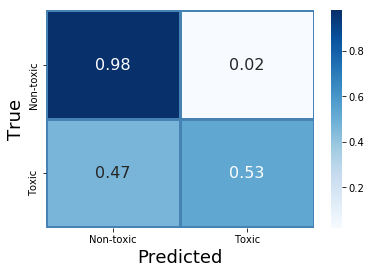


****  LogisticRegression  ***


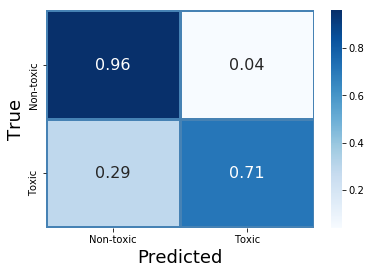


****  LinearSVC  ***


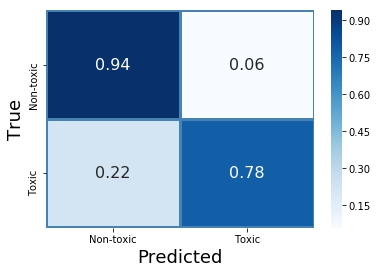

In [ ]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

Based on the above comparison, we could say that for these three models with default settings, **LinearSVC performs better than anyone for 'toxic' label .**




### Aggregated Hamming Loss Score


In [ ]:
# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [ ]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026939
1,LogisticRegression,0.025675
2,LinearSVC,0.028476


Across all models , **Logistic Regression** is doing a great job overall since it has the lowest percentage of incorrect labels.

<a id='Tuning'></a>
## Hyperparameter Tuning with Grid Search 

<a id='lr-tuning'></a>
### Logistic Regression Tuning

In [ ]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'class_weight': None, 'solver': 'liblinear'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

<a id='svm-tuning'></a>
### SVM Classifier Tuning

In [ ]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None}


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

###  Model Selection

We will then compare these two models based on their tunned hyperparameters, we will also include training time as one of the metric when we compare models.

In [ ]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_clf = lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='warn',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)

tunned_model_score_df = []
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [ ]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,LinearSVC,0.971706,0.971524,0.028476,5.029654
1,LogisticRegression,0.973227,0.974330,0.025670,13.031119


<a id='Ensembling'></a>
## Ensembling 

<a id='boosting'></a>
### Boosting Models

We tried 3 popular tree-based boosting models, and make a comparison for those models.

In [ ]:
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [ ]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for idx, label in enumerate(test_labels):
        start = timer()
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

### Scores After Boosting the Model

In [ ]:
boosting_score = pd.DataFrame(boosting_score_df,)
boosting_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Traing_Time']
boosting_score

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,AdaBoostClassifier,0.967605,0.969771,0.030229,50.761416
1,GradientBoostingClassifier,0.969075,0.971748,0.028252,204.453572
2,XGBClassifier,0.967563,0.971790,0.028210,68.613414


Since gradient boosting outperforms other two boosting models, we decide to go ahead with gradient boosting.

<a id='voting'></a>
### VotingClassifier

In [ ]:
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf),
                                            ('svm', svm_clf),
                                            ('xgb', xgb_clf)], voting='hard')
ensemble_score_df = []
f1_values = []
recall_values = []
hl = []
training_time = []

predict_df = pd.DataFrame()
predict_df['id'] = test_y['id']
for label in test_labels:
    start = timer()
    ensemble_clf.fit(X_train, train[label])
    training_time.append(timer() - start)
    predicted = ensemble_clf.predict(X_test)
    predict_df[label] = predicted
    f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                              predicted[test_y[label] != -1],
                              average="weighted"))
    recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                      predicted[test_y[label] != -1],
                                      average="weighted"))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                  predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

val = [name, mean(f1_values), mean(recall_values),
       hamming_loss_score, mean(training_time)]
ensemble_score_df.append(val)


# printing the values
ensemble_score = pd.DataFrame(ensemble_score_df,)
ensemble_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Training_Time']
ensemble_score

,Model,F1,Recall,Hamming_Loss,Training_Time
0,Ensemble,0.973026,0.974119,0.025881,64.728463


Note : Ensembled model worked very well but still could not outperform LinearSVC since we did not tune the hyperparameters for the ensemled model.

Analyzing the words misclassified by Logistic Classifier. Checking for 'toxic' label


In [ ]:
label = 'toxic'
lr = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
               intercept_scaling=1, loss='squared_hinge', max_iter=1000,
               multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
               verbose=0)
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined = pd.concat([test, test_y], axis=1)

In [ ]:
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text
commentCheck.shape

(1347,)

- Misclassified 1347 as non-toxic which were actually toxic

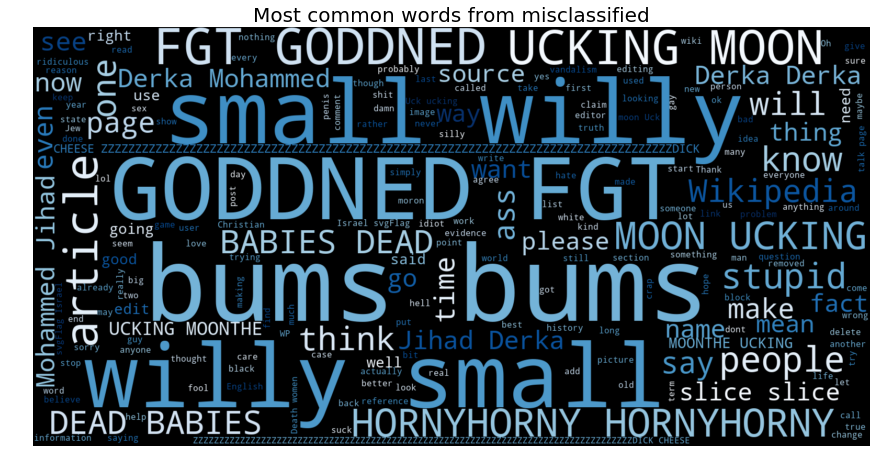

In [ ]:
# extract wrongly classified comments
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text

neg_Check = pd.Series(commentCheck).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,
                      max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

- We want to analyze why the model couldn't recognize these words. Were they not present in the training set? 
- In order to analyze, we first need to pass these raw comment strings through same tokenizer and check the common tokens.

In [ ]:
wrongWords = tokenize(neg_Check)
stop_words = stopwords.words('English')
wrongWords = [w for w in wrongWords if w not in stop_words]
cntr = Counter(wrongWords)
cntr.most_common(20)

[('bum', 352),
 ('ucking', 253),
 ('small', 244),
 ('willy', 238),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 200),
 ('like', 184),
 ('article', 184),
 ('hornyhorny', 174),
 ('stupid', 142),
 ('people', 142),
 ('derka', 140),
 ('dead', 134),
 ('know', 132),
 ('baby', 129),
 ('one', 122),
 ('wikipedia', 119),
 ('think', 116),
 ('would', 115)]

`ucking` is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

In [ ]:
neg_text_train = train['comment_text'].str.cat(sep=' ')
cntr_train = Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning rate curve for the estimator with title, training data as X, 
    labels as y.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="olive",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/nehatevathia/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

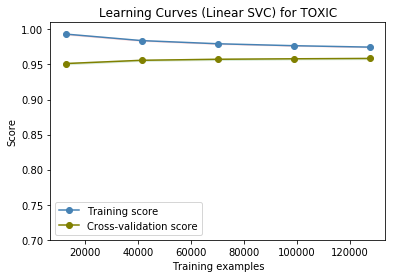

In [ ]:
title = "Learning Curves (Linear SVC) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
plot_learning_curve(estimator, title, X_train,
                    train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)